In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline 
# %matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator_tensorflow import get_batch, print_valid_characters

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

import tf_utils

# Attention Decoder
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
> </span>

Soft attention for recurrent neural networks have recently attracted a lot of interest.
These methods let the Decoder model selective focus on which part of the encoder sequence it will use for each decoded output symbol.
This relieves the encoder from having to compress the input sequence into a fixed size vector representation passed on to the decoder.
Secondly we can interrogate the decoder network about where it attends while producing the ouputs.
below we'll implement an decoder with selective attention and show that it significantly improves the performance of the toy translation task.

The seminal attention paper is https://arxiv.org/pdf/1409.0473v7.pdf

The principle of attention models is:

1. Use the encoder to get the hidden represention $\{h^1_e, ...h^n_e\}$ for each position in the input sequence.
2. For timestep $t$ in the decoder do for $m = 1...n$ : $a_{mt} = f(h^e_m, h^d_t)$. Where f is a function returning a scalar value.
4. Weight each $h^e_m$ by its probability $p_{mt}$ and sum to get $h_{in}$.
5. Use $h_{in}$ as an additional input to the decoder. $h_{in}$ is recalculated each time the decoder is updated.

In [2]:
# At the bottom of the script there is some code which saves the model.
# If you wish to restore your model from a previous state use this function.
load_model = False

In [3]:
# resetting the graph
tf.reset_default_graph()

# Setting up hyperparameters and general configs
MAX_DIGITS = 10
MIN_DIGITS = 5
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')

BATCH_SIZE = 16
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 8
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 16
NUM_UNITS_DEC = 16
NUM_UNITS_ATTN = 16


# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')

# Building the model

# first we build the embeddings to make our characters into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')

# forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)#python.ops.rnn_cell.GRUCell
enc_out, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)
# use below in case TF's does not work as intended
#enc_state, _ = tf_utils.encoder(X_embedded, X_len, 'encoder', NUM_UNITS_ENC)
#
#enc_state = tf.concat(1, [enc_state, enc_state])

# decoding
# note that we are using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
# check out tf_utils to see how you make your own decoder
dec_out, dec_out_valid, alpha_valid = \
    tf_utils.attention_decoder(enc_out, X_len, enc_state, t_embedded, t_len,
                               NUM_UNITS_DEC, NUM_UNITS_ATTN, t_embeddings,
                               W_out, b_out)

# reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
out_tensor_valid = tf.reshape(dec_out_valid, [-1, NUM_UNITS_DEC])

# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
out_tensor_valid = tf.matmul(out_tensor_valid, W_out) + b_out

# reshaping back to sequence
b_size = tf.shape(X_len)[0] # use a variable we know has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable we know has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable

out_shape = tf.concat([tf.expand_dims(b_size, 0),
                      tf.expand_dims(seq_len, 0),
                      tf.expand_dims(num_out, 0)],
                      axis=0)
out_tensor = tf.reshape(out_tensor, out_shape)
out_tensor_valid = tf.reshape(out_tensor_valid, out_shape)

## handling shape loss
y = out_tensor
y_valid = out_tensor_valid

### Defining the cost function, gradient clipping and accuracy

In [4]:
def loss_and_acc(preds):
    # sequence_loss_tensor is a modification of TensorFlow's own sequence_to_sequence_loss
    # TensorFlow's seq2seq loss works with a 2D list instead of a 3D tensors
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS) # notice that we use ts_out here!
    # if you want regularization
    reg_scale = 0.00001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use lobal step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)

# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)

## add below for clipping by norm
#gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
#clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
#grads_and_vars = zip(clipped_gradients, variables)

## apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

### Testing the forward pass

In [5]:
# print all the variable names and shapes
# notice that W_z is now packed, such that it contains both W_z_h and W_x_h, this is for optimization
# further, we now have W_s, b_s. This is so NUM_UNITS_ENC and NUM_UNITS_DEC does not have to share shape ..!
for var in tf.global_variables ():
    s = var.name + " "*(40-len(var.name))
    print (s, var.value().get_shape())

X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
W_out:0                                  (16, 11)
b_out:0                                  (11,)
rnn/gru_cell/gates/kernel:0              (24, 32)
rnn/gru_cell/gates/bias:0                (32,)
rnn/gru_cell/candidate/kernel:0          (24, 16)
rnn/gru_cell/candidate/bias:0            (16,)
decoder/W_s:0                            (16, 16)
decoder/b_s:0                            (16,)
decoder/W_z:0                            (40, 16)
decoder/W_r:0                            (40, 16)
decoder/W_c:0                            (40, 16)
decoder/b_z:0                            (16,)
decoder/b_r:0                            (16,)
decoder/b_c:0                            (16,)
decoder/W_a:0                            (16, 16)
decoder/U_a:0                            (1, 1, 16, 16)
decoder/b_a:0                            (16,)
decoder/v_a:0                            (16,)
global_step:0          

In [6]:
#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

X_val (5000, 55)
t_out_val (5000, 11)


In [7]:
## Start the session
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.global_variables_initializer())

Wall time: 11min 39s


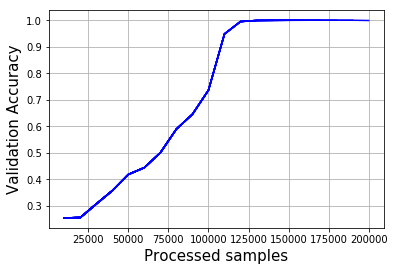

In [8]:
%%time 
## If you get an error, remove this line! It makes the error message hard to understand.

# NOTICE - THIS MIGHT TAKE UPTO 30 MINUTES ON CPU..!
# setting up running parameters
val_interval = 5000
samples_to_process = 2e5
samples_processed = 0
samples_val = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        # load data
        X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
        text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #if samples_processed % 1000 == 0: print batch_cost, batch_acc
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            fetches_val = [accuracy_valid, y_valid, alpha_valid]
            feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
             ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val, alp_val = res
            samples_val += [samples_processed]
            accs += [acc_val]
            plt.plot(samples_val, accs, 'b-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out_attention.png")
            display.display(display.Image(filename="out_attention.png"))
            display.clear_output(wait=True)
# NOTICE - THIS MIGHT TAKE UPTO 30 MINUTES ON CPU..!
except KeyboardInterrupt:
    pass

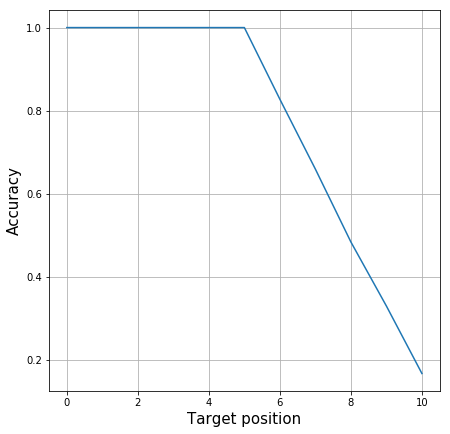

In [9]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

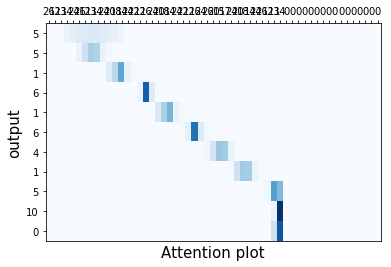

In [10]:
### attention plot, try with different i = 1, 2, ..., 1000
i = 42

column_labels = map(str, list(t_out_val[i]))
row_labels = map(str, (list(X_val[i])))
data = alp_val[i]
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

plt.ylabel('output', fontsize=15)
plt.xlabel('Attention plot', fontsize=15)

plt.show()

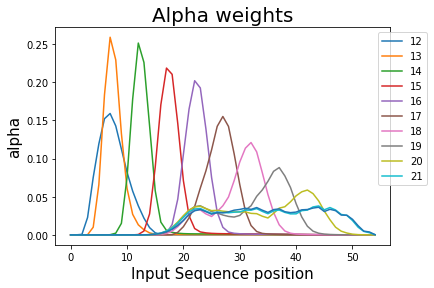

In [11]:
# Plot of average attention weight as a function of the sequence position for each of 
# the 21 targets in the output sequence i.e. each line is the mean postion of the 
# attention for each target position.

np.mean(alp_val, axis=0).shape
plt.figure()
plt.plot(np.mean(alp_val, axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,22)), bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()


In [12]:
## Save model
# Read more about saving and loading models at https://www.tensorflow.org/programmers_guide/saved_model

# Save model
save_path = tf.train.Saver().save(sess, "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)


Model saved in file: /tmp/model.ckpt


In [13]:
sess.close()

## Assignments for the attention decoder
1. Explain what the attention plot shows.
2. Explain what the alpha weights plot shows.
 3. Why are the alpha curve for the first digit narrow and peaked while later digits have alpha curves that are wider and less peaked?
4. Why is attention a good idea for this problem? Can you think of other problems where attention is a good choice?
 1. Compare the performance and training time (number of samples processed) for the models with and without attention.
5. Try setting MIN_DIGITS and MAX_DIGITS to 20
6. Enable gradient clipping (under the loss codeblock)